In [1]:
%matplotlib inline
import pandas as pd
import nivapy3 as nivapy
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import seaborn as sn
from calendar import monthrange

plt.style.use("ggplot")

In [2]:
# Connect to RESA
eng = nivapy.da.connect()

Username:  ···
Password:  ········


Connection successful.


# 1000 Lakes 2019 (Part 2: Process ERA5 data)

This notebook extracts ERA5 data for temperature, precipitation and runoff for the 1000 Lakes stations. The ERA5 dataset was downloaded from Copernicus [here](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview).

## 1. Get station co-ordinates 

The relevant project ID in RESA is 4530.

In [3]:
stn_df = nivapy.da.select_resa_project_stations([4530], eng)
stn_df.dropna(subset=["latitude", "longitude"], inplace=True)
print(len(stn_df), "station in project.")

# Save for use on Hub
csv_path = r'../output/resa_1000_lakes_stn_list.csv'
stn_df.to_csv(csv_path, index=False)

stn_df.head()

1003 station in project.


,station_id,station_code,station_name,latitude,longitude,altitude
0,3167,620-4-6,Ørteren,60.470,7.795,1147.0
1,3168,621-1-27,Flåvatna,60.200,9.183,855.0
2,3169,621-3-5,Soneren,60.061,9.545,104.0
3,3170,622-2-43,Trytetjern,60.213,9.764,275.0
4,3171,622-4-4,Krøderen,60.327,9.645,133.0


In [4]:
# Map
nivapy.spatial.quickmap(
    stn_df, popup="station_code", cluster=True,
)

## 2. ERA5

In [5]:
# Read nc
nc_path = r"../../../era5_tmp_pptn_runoff_1979-2019_monthly.nc"
ds = xr.open_dataset(nc_path)

# 'expver' = 1 is up to end of 2019; 'expver' = 2 is for most recent data
ds = ds.sel(expver=1).drop("expver")

ds = ds.load()

ds

<xarray.Dataset>
Dimensions:    (latitude: 121, longitude: 141, time: 496)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 34.25 34.5 34.75 35.0
  * latitude   (latitude) float32 85.0 84.75 84.5 84.25 ... 55.5 55.25 55.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-04-01
Data variables:
    t2m        (time, latitude, longitude) float32 248.33235 248.311 ... nan nan
    ro         (time, latitude, longitude) float32 0.0 0.0 0.0 ... nan nan nan
    tp         (time, latitude, longitude) float32 0.0005893726 ... nan
Attributes:
    Conventions:  CF-1.6
    history:      2020-05-20 15:24:14 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

### 2.1. Extract monthly data

Values for `tp` and `ro` are in mm/day (for the month), which is slightly awkward (see [here](https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation#ERA5:datadocumentation-Monthlymeans)). This will be easier to deal with in `pandas` *after* extracting monthly series for the station co-ordinates.

In [6]:
# Loop over sites
df_list = []
for idx, row in stn_df.iterrows():
    lat = row["latitude"]
    lon = row["longitude"]
    stn_id = row["station_id"]

    # Get time series
    df = (
        ds.sel(latitude=lat, longitude=lon, method="nearest")
        .to_dataframe()
        .reset_index()
    )
    df["station_id"] = stn_id
    df["year"] = df["time"].dt.year
    df["month"] = df["time"].dt.month

    df_list.append(df)

# Combine results
df = pd.concat(df_list, sort=True).reset_index(drop=True)
df = df[["station_id", "year", "month", "t2m", "tp", "ro"]]
df = df.melt(id_vars=["station_id", "year", "month"])

# Exclude 2020 as incomplete
df = df.query("year < 2020")

df.head()

,station_id,year,month,variable,value
0,3167,1979,1,t2m,259.627472
1,3167,1979,2,t2m,261.105865
2,3167,1979,3,t2m,265.302612
3,3167,1979,4,t2m,270.792725
4,3167,1979,5,t2m,272.508606


### 2.2. Aggregate to annual

In [7]:
def days_in_month(row):
    return monthrange(row["year"], row["month"])[-1]

In [8]:
# Add days in month
df["days_in_month"] = df.apply(days_in_month, axis=1)

# Weight values by days in month
df["month_accum"] = df["value"] * df["days_in_month"]

# Aggregate to annual
df = df.groupby(["station_id", "year", "variable"]).sum().reset_index()

# Calculate mean for temp; total for tp and ro; convert units
df.loc[df["variable"] == "t2m", "month_accum"] = (
    df["month_accum"] / df["days_in_month"]
) - 273.15  # K to C

df.loc[df["variable"] == "ro", "month_accum"] = df["month_accum"] * 1000  # m to mm

df.loc[df["variable"] == "tp", "month_accum"] = df["month_accum"] * 1000  # m to mm

# Tidy
df = df[["station_id", "year", "variable", "month_accum"]]
df.rename({"month_accum": "value"}, inplace=True, axis=1)

# Save
csv_path = r"../output/1000_lakes_temp_pptn_runoff.csv"
df.to_csv(csv_path, index=False)

df.head()

,station_id,year,variable,value
0,9,1979,ro,303.359131
1,9,1979,t2m,4.858453
2,9,1979,tp,950.880432
3,9,1980,ro,332.186523
4,9,1980,t2m,5.670587


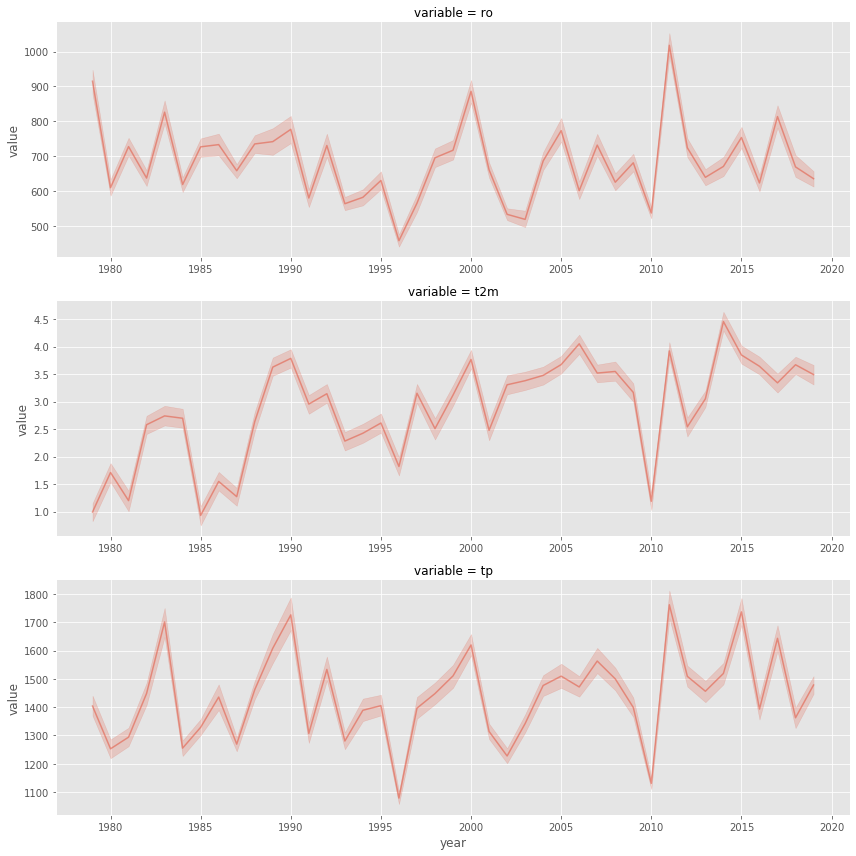

In [9]:
# Plot
sn.relplot(
    data=df,
    x="year",
    y="value",
    row="variable",
    height=4,
    aspect=3,
    kind="line",
    legend=False,
    alpha=0.5,
    facet_kws={"sharey": False, "sharex": False},
)

## 3. Add to database

### 3.1. Add metadata parameters to database

I have created new entries in the `station_parameter_definitions` table in RESA, as shown below.

In [10]:
# Get metadata IDs
sql = (
    "SELECT * FROM resa2.station_parameter_definitions "
    "WHERE entered_by = 'JES' "
    "AND entered_date = DATE '2020-05-26'"
)
par_df = pd.read_sql(sql, eng)

par_df

,var_id,var_name,unit,type,explanation,category,entered_by,entered_date
0,341,ERA5 mean annual temperature 1995,C,n,"Parameter ""t2m"" in ERA5",2,JES,2020-05-26
1,342,ERA5 total annual precipitation 1995,mm,n,"Parameter ""tp"" in ERA5",2,JES,2020-05-26
2,343,ERA5 total annual runoff 1995,mm,n,"Parameter ""ro"" in ERA5",2,JES,2020-05-26
3,344,ERA5 mean annual temperature 2019,C,n,"Parameter ""t2m"" in ERA5",2,JES,2020-05-26
4,345,ERA5 total annual precipitation 2019,mm,n,"Parameter ""tp"" in ERA5",2,JES,2020-05-26
5,346,ERA5 total annual runoff 2019,mm,n,"Parameter ""ro"" in ERA5",2,JES,2020-05-26
6,347,ERA5 mean annual temperature 1981 - 2010,C,n,"Parameter ""t2m"" in ERA5; mean of mean annual t...",2,JES,2020-05-26
7,348,ERA5 mean annual precipitation 1981 - 2010,mm,n,"Parameter ""tp"" in ERA5; mean of total annual t...",2,JES,2020-05-26
8,349,ERA5 mean annual runoff 1981 - 2010,mm,n,"Parameter ""ro"" in ERA5; mean of total annual t...",2,JES,2020-05-26


### 3.2. Extract data of interest

In [11]:
# 1995
df_1995 = df.query("year == 1995").copy()
df_1995["var_id"] = df_1995["variable"].replace({"t2m": 341, "tp": 342, "ro": 343})
df_1995 = df_1995[["station_id", "var_id", "value"]]

# 2019
df_2019 = df.query("year == 2019").copy()
df_2019["var_id"] = df_2019["variable"].replace({"t2m": 344, "tp": 345, "ro": 346})
df_2019 = df_2019[["station_id", "var_id", "value"]]

# Average 1981 - 2010
df_ltav = df.query("1981 <= year <= 2010").copy()
df_ltav = df_ltav.groupby(["station_id", "variable"]).mean().reset_index()
df_ltav["var_id"] = df_ltav["variable"].replace({"t2m": 347, "tp": 348, "ro": 349})
df_ltav = df_ltav[["station_id", "var_id", "value"]]

# Combine
stn_par_df = pd.concat([df_1995, df_2019, df_ltav], axis=0)

stn_par_df.head()

,station_id,var_id,value
48,9,343,338.681183
49,9,341,6.901147
50,9,342,835.273987
171,10,343,221.076141
172,10,341,5.603937


### 3.3. Add to database

In [14]:
#stn_par_df.to_sql(
#   "stations_par_values",
#   schema="resa2",
#   con=eng,
#   if_exists="append",
#   index=False,
#)